In [ ]:
'''
Overall Goal: Quantify number of cells that are Brdu positive from nuclear staining.  
We will segment the nuceli, then meausre the Ki67 stianing intensity for each nucleus.

Using images from Q Wei, et al. "CDesign, Synthesis, and In Vitro and In Vivo Biological Studies of a 
3′-Deoxythymidine Conjugate that Potentially Kills Cancer Cells Selectively." December 2012PLoS ONE 7(12):e52199.
'''

In [1]:
import matplotlib.pyplot as plt
import skimage.io
import pandas as pd
import seaborn as sns

from cellpose import models, io, plot
from os import listdir
from os.path import join
from skimage.measure import regionprops
from skimage.color import rgb2gray

In [2]:
#First, load in images.
#We have for this example: nuclear staining and BrdU staining
mypath = "BrdU Images/"

nuc_filenames = [x for x in listdir(mypath) if "nuc" in x]
brdu_filenames = [x for x in listdir(mypath) if "BrdU" in x]

imgs_nuc = [skimage.io.imread(join(mypath, x)) for x in nuc_filenames]
imgs_brdu = [skimage.io.imread(join(mypath, x)) for x in nuc_filenames]

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 16.90s; flow+mask computation 0.54
estimated masks for 1 image(s) in 17.46 sec
>>>> TOTAL TIME 17.46 sec


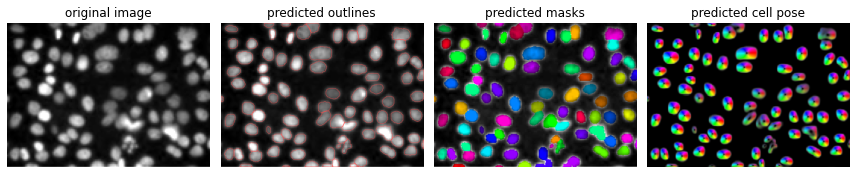

processing 1 image(s)
time spent: running network 15.93s; flow+mask computation 0.41
estimated masks for 1 image(s) in 16.36 sec
>>>> TOTAL TIME 16.36 sec


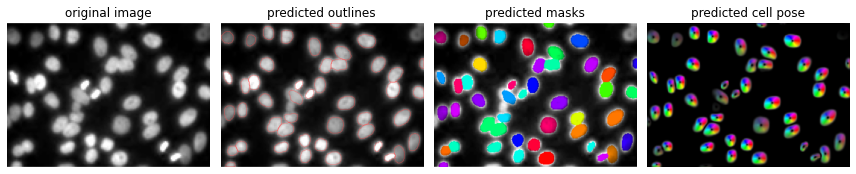

processing 1 image(s)
time spent: running network 15.62s; flow+mask computation 0.49
estimated masks for 1 image(s) in 16.13 sec
>>>> TOTAL TIME 16.13 sec


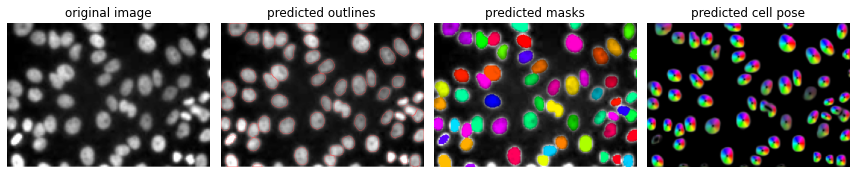

In [3]:
#segment nuclei using Cellpose and Meausure BrdU intensity 
model = models.Cellpose(model_type = "nuclei")
chan = [[0,0]]

nuc_areas_all = []
brdu_intensity_all = []
cell_line_all = []
condition_all = []

for i in range(len(imgs_nuc)):
    img_nuc = imgs_nuc[i]
    img_brdu = imgs_brdu[i]
   
    #perform segmentation
    masks, flows, styles, diams = model.eval(img_nuc, diameter = 35.0, channels = chan)

    #measure nuclei area
    nuc_props = regionprops(masks)
    nuc_areas = [region.area for region in nuc_props]

    #now meausre the BrdU signal for each nucleus
    brdu_props = regionprops(masks, img_brdu)
    brdu_intensity = [region.mean_intensity for region in brdu_props]
    
    #save info from filenames
    cell_line = [nuc_filenames[i].split("_")[2] for x in nuc_areas] #make dimension match above measurements
    condition = [nuc_filenames[i].split("_")[1] for x in nuc_areas] #make dimension match above measurements

    #save results to "all" arrays
    nuc_areas_all = nuc_areas_all + nuc_areas
    brdu_intensity_all = brdu_intensity_all + brdu_intensity
    cell_line_all = cell_line_all + cell_line
    condition_all = condition_all + condition
    
    #Show results of segmentation.  
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img_nuc, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()

#organize measurements into a dataframe
df = pd.DataFrame()
df["Cell Line"] = cell_line_all
df["Condition"] = condition_all
df["Nuclei Area (px2)"] = nuc_areas_all
df["BrdU Mean Intensity (AU)"] = brdu_intensity_all

#remove .tif ending from Cell Line column
df["Cell Line"] = df["Cell Line"].str.rstrip('.tif')

Text(0.5, 1.0, 'Nuclei Area')

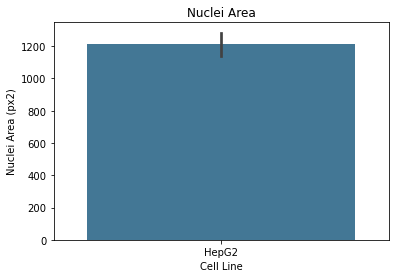

In [49]:
#plot nuclei area measurements
hue_order = ["DMSO", "dT-QX10uM", "dT-QX50uM"]


ax = sns.barplot(data = df, x = "Cell Line", y = "Nuclei Area (px2)",
                 hue_order = hue_order, palette = "mako")
ax.set_title("Nuclei Area")


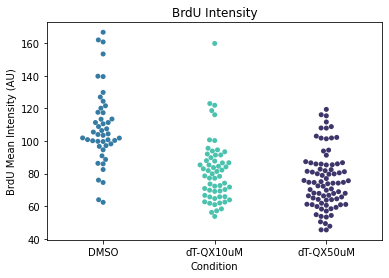

In [43]:
#plot BrdU Intensity measurements
order = ["DMSO", "dT-QX10uM", "dT-QX50uM"]

ax = sns.swarmplot(data = df, x = "Condition", y = "BrdU Mean Intensity (AU)", hue = "Condition", 
                 order = order, palette = "mako", dodge = False)
ax.set_title("BrdU Intensity")
ax.get_legend().remove()

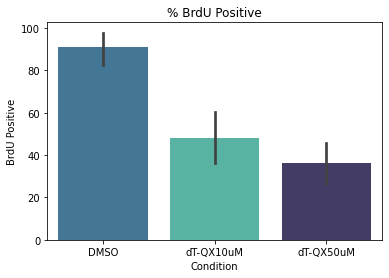

In [46]:
#Find the percent that are BrdU positive
#Threshold values should be determined using a control (e.g. cells you are sure are not entering S-phase)

df["BrdU Positive"] = [100 if i > 80 else 0 for i in df["BrdU Mean Intensity (AU)"]]

order = ["DMSO", "dT-QX10uM", "dT-QX50uM"]

ax = sns.barplot(data = df, x = "Condition", y = "BrdU Positive", hue = "Condition", 
                 order = order, palette = "mako", dodge = False)
ax.set_title("% BrdU Positive")
ax.get_legend().remove()